In [1]:
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

np.seterr(divide='ignore', invalid='ignore')

rng = default_rng()

mean = 0.
sd = 0.01

steps = 200000

In [2]:
model_tags = ['ucb', 'ucb_cnst', 'opt', 'grd', 'eps', 'cnst']
bounds = {}

# UCB
bounds['ucb'] = (-4,2)

# UCB const
bounds['ucb_cnst'] = (-4,2)

# greedy optimistic alfa = 0.1
bounds['opt'] = (-2,2)

# gradient bandit
bounds['grd'] = (-5,2)

# eps-greedy
bounds['eps'] = (-7,-2)

# constant eps-greedy
bounds['cnst'] = (-7,-2)


In [3]:
class KABModel:
    def __init__(self, type, coef):
        self.coef = np.power(2.,coef)
        if type == 'opt':
            self.q = np.full(10,self.coef)
        else:
            self.q = np.zeros(10)
        self.type = type
        self.chosen = None
        self.alfa = 0.1
        if type in ('ucb', 'ucb_cnst', 'eps'):
            self.n = np.zeros(10)
        if type in ('ucb', 'ucb_cnst'):
            self.t = 0
        if type == 'grd':
            self.pie = None
            self.r_avg = None


    
    def action(self):
        if self.type in ('ucb', 'ucb_cnst'):
            self.t += 1
            self.chosen = np.argmax(self.q + self.coef * np.sqrt(np.log(self.t)/self.n))
        elif self.type == 'opt':
            self.chosen = np.argmax(self.q)
        elif self.type == 'grd':
            self.pie = np.exp(self.q)/np.sum(np.exp(self.q))
            self.chosen = rng.choice(10,p=self.pie)
        elif self.type in ('eps', 'cnst'):
            self.chosen = rng.integers(0,10) if rng.random() < self.coef else np.argmax(self.q)
        return self.chosen

    
    def update(self, value):
        if self.type in ('ucb', 'eps'):
            self.n[self.chosen] += 1
            self.q[self.chosen] += (value - self.q[self.chosen])/self.n[self.chosen]
        elif self.type == 'ucb_cnst':
            self.n[self.chosen] += 1
            self.q[self.chosen] += (value - self.q[self.chosen])*self.alfa
        elif self.type in ('opt', 'cnst'):
            self.q[self.chosen] += (value - self.q[self.chosen])*self.alfa
        elif self.type == 'grd':
            if self.r_avg is None:
                self.r_avg = value
            else:
                x = np.full(10,0.)
                x[self.chosen] = 1.
                self.q += self.coef * (value - self.r_avg) * (x - self.pie)
                self.r_avg += (value - self.r_avg)*self.alfa
        self.chosen = None


In [4]:
models = []
for tag in model_tags:
    for c in range(bounds[tag][0],bounds[tag][1]+1):
        models.append(KABModel(tag,c))

In [5]:
q_true = [0.]*10
res = {md:0. for md in models}
k = 0

for st in tqdm(range(steps)):
    # true
    for i in range(10):
        q_true[i] += rng.normal(mean,sd)

    for md in models:
        r = q_true[md.action()]
        md.update(r)
        if st > steps/2:
            k += 1
            res[md] += (r - res[md])/k
        

100%|██████████| 200000/200000 [02:10<00:00, 1532.27it/s]


In [6]:
results = pd.DataFrame()
for md in models:
    results.loc[md.coef,md.type] = res[md]

<AxesSubplot:>

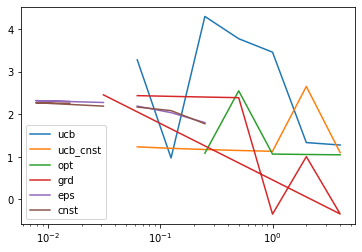

In [10]:
results.plot(logx=True)